In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import seaborn as sns
sns.set_theme(style="whitegrid")

This code searches for the minimum timescale separation (epoch length) $\tau$ such that the combined Stackeleberg---or performatively stable equilibrium (PSE) seeking---dynamics are stable. Change the parameter `PSE=True` to check for the latter and otherwise it searches for the former.

In [2]:

def check_schur_complement(A, B, C, D):
    """
    Check if the Schur complement A-BD^(-1)C has positive eigenvalues
    """
    try:
        D_inv = np.linalg.inv(D)
        schur = A - B @ D_inv @ C
        eigenvals = np.linalg.eigvals(schur)
        return np.all(np.real(eigenvals) > 0), eigenvals, schur
    except np.linalg.LinAlgError:
        return False, None, None

def create_random_block_matrix(n, m, min_val=-5, max_val=5, eta=0.1):
    """
    Creates a random block matrix with additional check for Schur complement
    """
    while True:  # Keep trying until we get a matrix with positive Schur complement
        # Create random blocks with uniform distribution
        B = np.random.uniform(min_val, max_val, (n, m))
        C = np.random.uniform(min_val, max_val, (m, n))
        
        # Create positive definite A
        X_A = np.random.uniform(min_val, max_val, (n, n))
        Q_A, _ = np.linalg.qr(X_A)
        eigenvals_A = np.random.uniform(0, max_val, n)
        A = Q_A @ np.diag(eigenvals_A) @ Q_A.T
        
        # Create positive definite D
        X_D = np.random.uniform(min_val, max_val, (m, m))
        Q_D, _ = np.linalg.qr(X_D)
        eigenvals_D = np.random.uniform(0, max_val, m)
        D = Q_D @ np.diag(eigenvals_D) @ Q_D.T
        
        # Check Schur complement
        schur_positive, schur_eigs, schur = check_schur_complement(A, B, C, D)
        
        # Create the full block matrix [A,B;C,D] before scaling
        top_blocks = np.hstack([A, B])
        bottom_blocks = np.hstack([C, D])
        full_block_matrix = np.vstack([top_blocks, bottom_blocks])
        
        # Check if full block matrix has at least one negative eigenvalue
        full_block_eigs = np.linalg.eigvals(full_block_matrix)
        has_negative_eig = np.any(np.real(full_block_eigs) < 0)
        
        if schur_positive and has_negative_eig:
            # Create the final matrix I - η[A,B;C,D]
            result = np.eye(n + m) - eta * full_block_matrix
            return result, A, D, B, C, schur_eigs, schur, full_block_matrix, full_block_eigs

def compute_second_matrix(matrix, n, m, eta):
    """
    Compute I - η[0,0;C,D] from the original matrix I - η[A,B;C,D]
    """
    full_size = n + m
    second_matrix = np.eye(full_size)
    # Extract C and D blocks from original matrix
    second_matrix[n:, :n] = matrix[n:, :n]
    second_matrix[n:, n:] = matrix[n:, n:]
    return second_matrix

def check_matrix_properties(matrix, n, m, eta, A_block, D_block, B_block, C_block, full_block_matrix, full_block_eigs, min_tau=5, max_tau=20,PSE=False):
    """
    Check all matrix properties:
    1. Block diagonals (I-ηA and I-ηD) have eigenvalues in unit circle
    2. Full matrix has at least one eigenvalue outside unit circle
    3. If PSE, 
        - Check that A has positive eigenvalues
       Else (stack case)
        - Schur complement A-BD^(-1)C has positive eigenvalues
    4. If stack, Full block matrix [A,B;C,D] has at least one negative eigenvalue
    5. Product matrix with τ ≥ min_tau has all eigenvalues in unit circle
    """
    # Check block diagonal eigenvalues of original matrix
    I_minus_etaA = np.eye(n) - eta * A_block
    I_minus_etaD = np.eye(m) - eta * D_block
    A_block_eigs = np.linalg.eigvals(I_minus_etaA)
    D_block_eigs = np.linalg.eigvals(I_minus_etaD)
    blocks_stable = np.all(np.abs(A_block_eigs) < 1) and np.all(np.abs(D_block_eigs) < 1)
    A_block_nash = np.all(np.abs(A_block) > 0)
    # Check Schur complement
    schur_positive, schur_eigs, schur = check_schur_complement(A_block, B_block, C_block, D_block)
    #if not schur_positive:
    #    return False, None, None
    
    # Check that full block matrix has at least one negative eigenvalue
    has_negative_eig = np.any(np.real(full_block_eigs) < 0)
    if not has_negative_eig:
        return False, None, None
    
    # Check full matrix eigenvalues
    full_eigs = np.linalg.eigvals(matrix)
    full_unstable = np.any(np.abs(full_eigs) > 1)
    
    if not (blocks_stable and full_unstable):
        return False, None, None
    
    if PSE: # Performative stable case
        if not A_block_nash:
            return False, None, None
    else: # stack case
        if not schur_positive:
            return False, None, None
    # Compute second matrix
    second_matrix = compute_second_matrix(matrix, n, m, eta)
    
    # Verify that all tau < min_tau are unstable
    for tau in range(1, min_tau):
        product = matrix @ np.linalg.matrix_power(second_matrix, tau)
        product_eigs = np.linalg.eigvals(product)
        if np.all(np.abs(product_eigs) < 1):
            return False, None, None
    
    # Search for stabilizing tau >= min_tau
    for tau in range(min_tau, max_tau + 1):
        product = matrix @ np.linalg.matrix_power(second_matrix, tau)
        product_eigs = np.linalg.eigvals(product)
        
        if np.all(np.abs(product_eigs) < 1):
            tau_history = []
            for t in range(1, tau + 3):
                prod = matrix @ np.linalg.matrix_power(second_matrix, t)
                tau_history.append({
                    'tau': t,
                    'eigenvalues': np.linalg.eigvals(prod),
                    'max_magnitude': np.max(np.abs(np.linalg.eigvals(prod)))
                })
            
            return True, tau, {
                'I_minus_etaA': I_minus_etaA,
                'I_minus_etaD': I_minus_etaD,
                'A_eigs': A_block_eigs,
                'D_eigs': D_block_eigs,
                'full_eigs': full_eigs,
                'second_matrix': second_matrix,
                'second_matrix_eigs': np.linalg.eigvals(second_matrix),
                'product_eigs': product_eigs,
                'product_matrix': product,
                'max_A_eig': np.max(np.abs(A_block_eigs)),
                'max_D_eig': np.max(np.abs(D_block_eigs)),
                'max_full_eig': np.max(np.abs(full_eigs)),
                'max_product_eig': np.max(np.abs(product_eigs)),
                'tau_history': tau_history,
                'schur_eigs': schur_eigs,
                'schur': schur,
                'full_block_matrix': full_block_matrix,
                'full_block_eigs': full_block_eigs,
                'min_block_eig': np.min(np.real(full_block_eigs))
            }
    
    return False, None, None

def search_for_interesting_case(n, m, range_seeds=(0,1000), eta=0.1, min_val=-5, max_val=5, min_tau=5, max_tau=20, PSE=False):
    """
    Search over multiple seeds for a case where tau >= min_tau is needed
    """
    for seed in range(range_seeds[0], range_seeds[1]):
        np.random.seed(seed)
        
        try:
            matrix, A_block, D_block, B_block, C_block, schur_eigs, schur, full_block_matrix, full_block_eigs = create_random_block_matrix(
                n, m, min_val, max_val, eta
            )
            
            is_interesting, tau, eig_data = check_matrix_properties(
                matrix, n, m, eta, A_block, D_block, B_block, C_block, 
                full_block_matrix, full_block_eigs, min_tau, max_tau, PSE
            )
            
            if is_interesting:
                print(f"\nFound interesting case with seed {seed}!")
                print(f"First stabilizing tau = {tau} (minimum required was {min_tau})")
                print(f"Using matrix entries in range [{min_val}, {max_val}]")
                
                print("\nFull block matrix [A,B;C,D] eigenvalues:")
                print(full_block_eigs)
                print(f"Minimum real part: {np.min(np.real(full_block_eigs)):.4f}")
                
                print("\nSchur complement eigenvalues:")
                print(schur_eigs)
                print(f"Min real part: {np.min(np.real(schur_eigs)):.4f}")
                
                print("\nEigenvalue magnitude progression:")
                for hist in eig_data['tau_history']:
                    print(f"tau = {hist['tau']}: max eigenvalue magnitude = {hist['max_magnitude']:.4f}")
                
                print("\nOriginal matrix (I - η[A,B;C,D]):")
                print(matrix)
                print(f"Max eigenvalue magnitude: {eig_data['max_full_eig']:.4f}")
                
                print("\nMatrix entry statistics:")
                print(f"Min entry: {np.min(matrix)}")
                print(f"Max entry: {np.max(matrix)}")
                print(f"Mean entry: {np.mean(matrix):.4f}")
                
                return seed, tau, matrix, eig_data
        except Exception as e:
            print(f"Error with seed {seed}: {str(e)}")
            continue
    
    print("No interesting cases found after", num_seeds, "attempts")
    return None, None, None, None




Found interesting case with seed 301!
First stabilizing tau = 6 (minimum required was 5)
Using matrix entries in range [-10, 10]

Full block matrix [A,B;C,D] eigenvalues:
[-0.51736238+3.99224547j -0.51736238-3.99224547j  7.18565862+0.j
  7.00667458+6.48139097j  7.00667458-6.48139097j]
Minimum real part: -0.5174

Schur complement eigenvalues:
[7.00218809+8.2389268j 7.00218809-8.2389268j 9.2611592 +0.j       ]
Min real part: 7.0022

Eigenvalue magnitude progression:
tau = 1: max eigenvalue magnitude = 1.0968
tau = 2: max eigenvalue magnitude = 1.0687
tau = 3: max eigenvalue magnitude = 1.0452
tau = 4: max eigenvalue magnitude = 1.0252
tau = 5: max eigenvalue magnitude = 1.0075
tau = 6: max eigenvalue magnitude = 0.9918
tau = 7: max eigenvalue magnitude = 0.9776
tau = 8: max eigenvalue magnitude = 0.9649

Original matrix (I - η[A,B;C,D]):
[[ 0.76111742  0.15726798  0.01015182  0.73785665 -0.69106266]
 [ 0.15726798  0.47961296 -0.13392414 -0.50038575 -0.203865  ]
 [ 0.01015182 -0.13392414

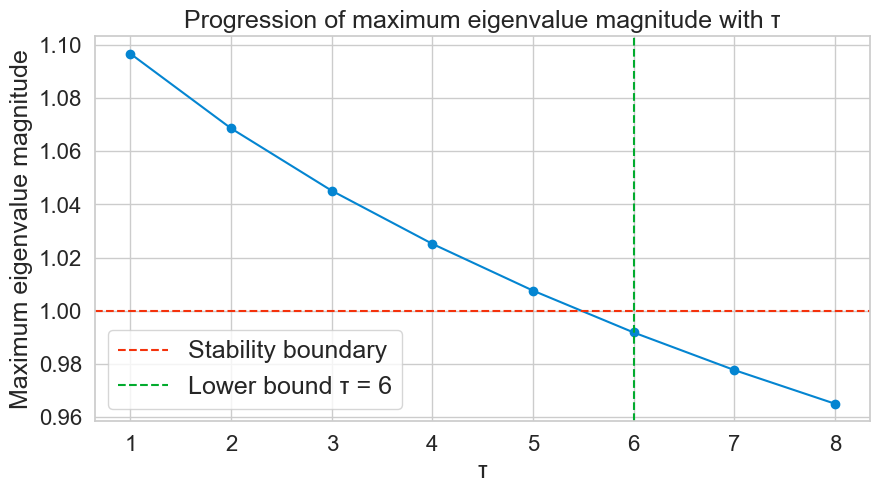

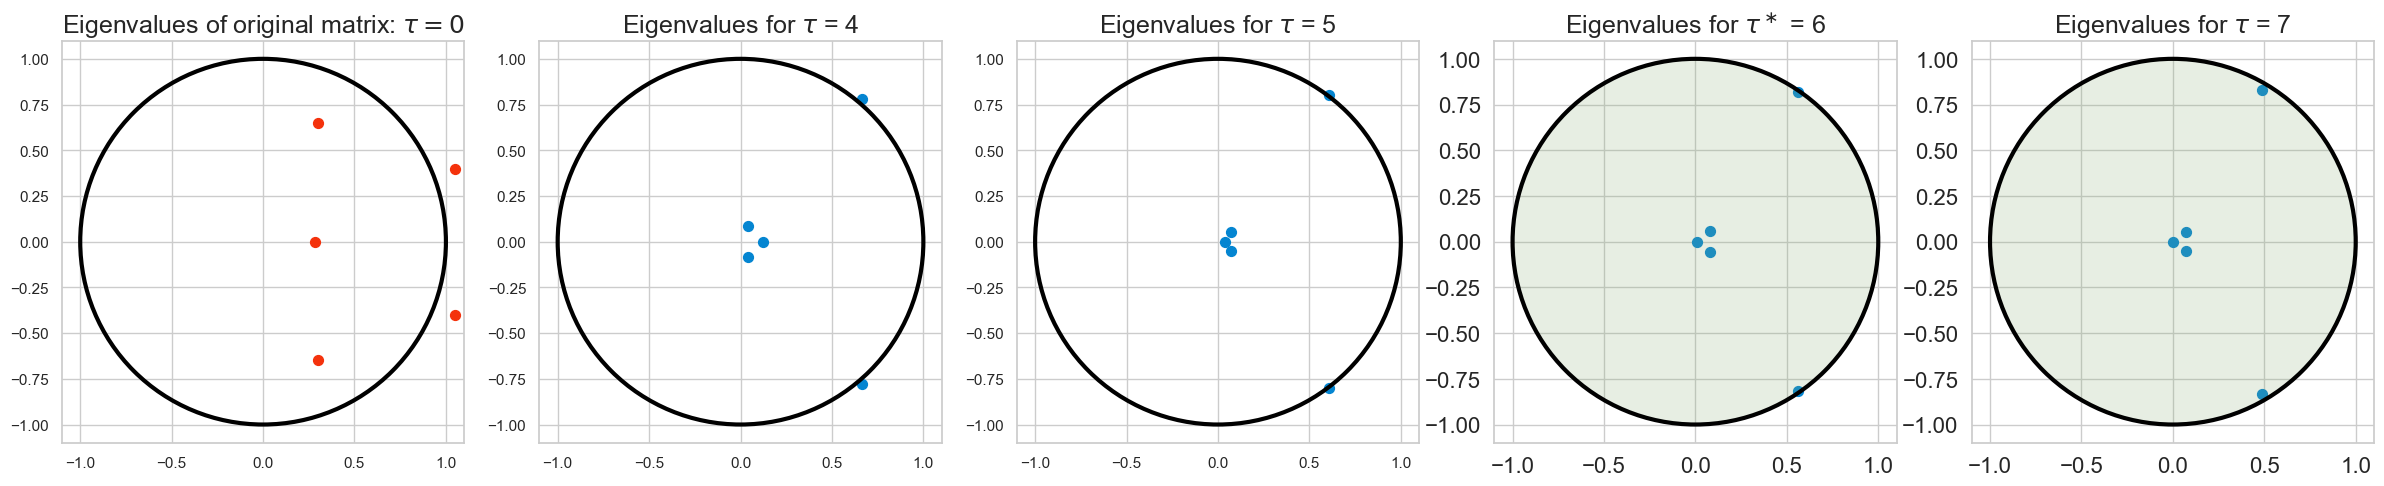

In [6]:
# Run the search
if __name__ == "__main__":
    n, m = 3, 2
    eta = 0.1
    min_tau = 5
    max_tau = 20
    min_val = -10
    max_val = 10
    fs= 18
    PSE=True
    ms=50

    seed, tau, matrix, eig_data = search_for_interesting_case(
        n, m, 
        range_seeds=(300,1000),
        eta=eta,
        min_val=min_val,
        max_val=max_val,
        min_tau=min_tau,
        max_tau=max_tau,
        PSE=PSE
    )
    sage_color = mcolors.to_rgba('xkcd:sage', alpha=0.2)
    red_color = mcolors.to_rgba('xkcd:vermillion', alpha=0.2)
    xlim = (-1.1, 1.1)
    ylim = (-1.1,1.1)
    if seed is not None:
        # Plot eigenvalues
        plt.figure(figsize=(10, 5))
        taus = [hist['tau'] for hist in eig_data['tau_history']]
        max_mags = [hist['max_magnitude'] for hist in eig_data['tau_history']]
        plt.plot(taus, max_mags, 'o-', color='xkcd:cerulean')
        plt.axhline(y=1, color='xkcd:vermillion', linestyle='--', label='Stability boundary')
        #plt.axvline(x=min_tau, color='xkcd:kelly green', linestyle='--', label=f'Minimum required τ = {min_tau}')
        plt.axvline(x=tau, color='xkcd:kelly green', linestyle='--', label=f'Lower bound τ = {tau}')
        plt.xlabel('τ', fontsize=fs )
        plt.ylabel('Maximum eigenvalue magnitude', fontsize=fs)
        plt.title('Progression of maximum eigenvalue magnitude with τ', fontsize=fs)
        plt.grid(True)
        plt.legend(fontsize=fs)
        plt.tick_params(axis='both', which='major', labelsize=fs-2)
        plt.savefig(f"tau_progression_plot_{seed}_{min_tau}.png")
        # Plot eigenvalue locations
        plt.figure(figsize=(24, 5))
        # Original matrix eigenvalues
        plt.subplot(151)
        plt.scatter(np.real(eig_data['full_eigs']), np.imag(eig_data['full_eigs']),s=ms, color='xkcd:vermillion')
        circle = plt.Circle((0, 0), 1, fill=False, color='xkcd:black', linewidth=3)
        plt.gca().add_artist(circle)
        plt.gca().set_aspect('equal')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.title(r'Eigenvalues of original matrix: $\tau=0$',fontsize=fs)
        plt.grid(True)
        
        # Plot for tau = min_tau - 1
        plt.subplot(152)
        eigs_before = eig_data['tau_history'][min_tau-2]['eigenvalues']
        plt.scatter(np.real(eigs_before), np.imag(eigs_before),s=ms, color='xkcd:cerulean')
        circle = plt.Circle((0, 0), 1, fill=False, color='xkcd:black', linewidth=3)
        plt.gca().add_artist(circle)
        
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.gca().set_aspect('equal')
        plt.title(fr'Eigenvalues for $\tau$ = {min_tau-1}', fontsize=fs)
        plt.grid(True)
        
        # Plot for tau = min_tau
        plt.subplot(153)
        eigs_at_min = eig_data['tau_history'][min_tau-1]['eigenvalues']
        plt.scatter(np.real(eigs_at_min), np.imag(eig_data['tau_history'][min_tau-1]['eigenvalues']),s=ms, color='xkcd:cerulean')
        circle = plt.Circle((0, 0), 1, fill=False, color='xkcd:black', linewidth=3)
        plt.gca().add_artist(circle)
        plt.gca().set_aspect('equal') 
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.title(fr'Eigenvalues for $\tau$ = {min_tau}', fontsize=fs)
        plt.grid(True)
        
        # Final stabilizing tau
        plt.subplot(154)
        plt.scatter(np.real(eig_data['product_eigs']), np.imag(eig_data['product_eigs']),s=ms, color='xkcd:cerulean')
        circle = plt.Circle((0, 0), 1, fill=True, edgecolor='xkcd:black', facecolor=sage_color, linewidth=3)
        plt.gca().add_artist(circle)
        plt.gca().set_aspect('equal')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.title(fr'Eigenvalues for $\tau^\ast$ = {tau}', fontsize=fs)
        plt.grid(True)
        plt.tick_params(axis='both', which='major', labelsize=fs-2)

        # One past stabilizing tau
        plt.subplot(155)
        eigs= eig_data['tau_history'][tau+1]['eigenvalues']
        plt.scatter(np.real(eigs), np.imag(eig_data['tau_history'][tau+1]['eigenvalues']),s=ms, color='xkcd:cerulean',zorder=1)
        circle = plt.Circle((0, 0), 1, fill=True, edgecolor='xkcd:black', facecolor=sage_color, linewidth=3)
        plt.gca().add_artist(circle)
        plt.gca().set_aspect('equal')
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.title(rf'Eigenvalues for $\tau$ = {tau+1}', fontsize=fs)
        plt.grid(True)
        plt.tick_params(axis='both', which='major', labelsize=fs-2)
        plt.tight_layout()
        plt.savefig(f"taus_spectrum_plot_{seed}_{min_tau}.png")

In [40]:
xlim

(-2, 2)